In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..//')

c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\notebooks
c:
Users
sceac10
c:\sceac10\


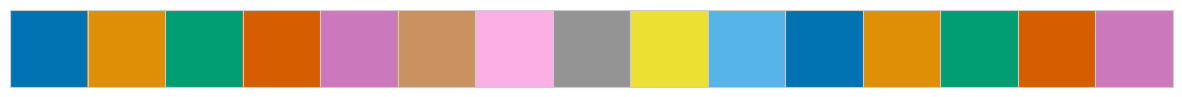

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import seaborn as sns
import sys
import random

from src.common import enums
from pathlib import Path

random.seed(42)

# blues = [x for x in reversed(sns.color_palette("Blues_d", 11))]
# sns.set_palette(sns.color_palette("Paired", 10))
# sns.set_style("white")
sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
export_fig_format = "pdf"
fig_format = "png"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)
sns.palplot(sns.color_palette())

markers = ['P', 'o', '^', 's', '*', 'v']
linewidth = 0.1
edgecolor = 'black'

print(os.getcwd())
computer_path= ""
for x in os.getcwd().split(os.path.sep):
    print(x)
    computer_path=computer_path+x+os.path.sep
    if x == "sceac10":
        break    
    else: computer_path = os.getcwd().split(os.path.sep)[0]+os.path.sep
print(computer_path)


In [4]:
PATH_TABLES = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\General\communication\tables")
PATH_SAVE_FIGURES = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\General\communication\figures")

## Number of households - projection from FES 2023 - Consumer transformation - NZ.22-NZ.25: Estimated number of heating technologies and the associated emissions reduction to 2050

In [5]:
fn = "Dwellings_size.csv"
dataf = pd.read_csv(PATH_TABLES/fn, index_col=0, thousands=r',')
dataf = dataf.dropna(how='any').T
dataf = dataf/1000000
dataf.head()

Year,Number of households
2020,28.762037
2021,28.875423
2022,29.009595
2023,29.133375
2024,29.257157


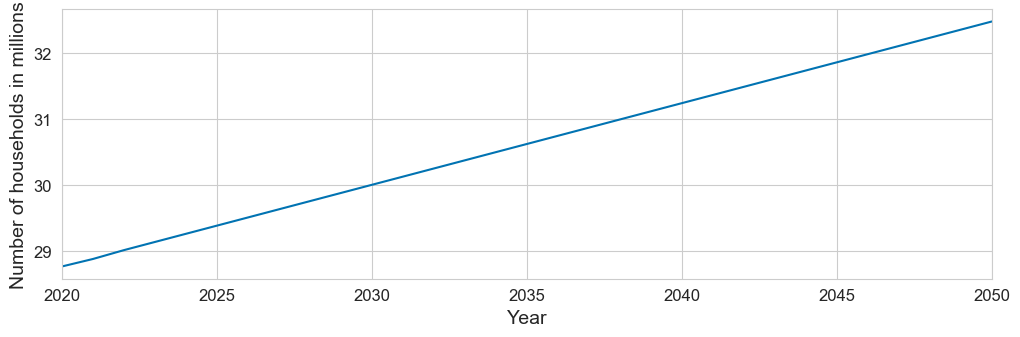

In [6]:
fig, ax = plt.subplots(figsize=figsize)
dataf.plot(ax=ax)
ax.set_ylabel('Number of households in millions')
ax.set_xlabel('Year')
ax.legend().remove()
ax.margins(0, None)

fig.savefig(PATH_SAVE_FIGURES/f"dwelling_projections.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"dwelling_projections.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

## Normalised profile for equipment gains

In [9]:
PATH_EQUIPMENT_GAINS_PROFILE = Path(r'C:\Users\sceac10\OneDrive - Cardiff University\General\resources\Equipment_gain_profile_TM59.xlsx')
SHEET_EQUIPMENT_GAINS_PROFILE = 'Normalised'

equipment_gains_df = pd.read_excel(PATH_EQUIPMENT_GAINS_PROFILE, sheet_name=SHEET_EQUIPMENT_GAINS_PROFILE, index_col=0)

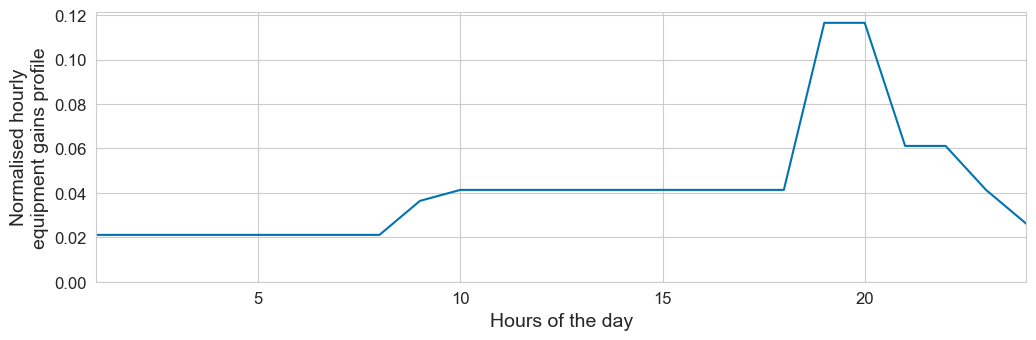

In [19]:



fig, ax = plt.subplots(figsize=figsize)
equipment_gains_df.loc['Normalised profile', :].plot(ax=ax)
ax.set_ylabel('Normalised hourly\nequipment gains profile')
ax.set_xlabel('Hours of the day')
ax.legend().remove()
ax.margins(0, None)
ax.set_ylim(0, None)

fig.savefig(PATH_SAVE_FIGURES/f"equipment_gains.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"equipment_gains.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

,Normalised profile
1,0.021090
2,0.021090
3,0.021090
4,0.021090
5,0.021090
6,0.021090
7,0.021090
8,0.021090
9,0.036397
10,0.041345
